# 1. Import Dependent Libs and Set Paths

In [1]:
import os
import numpy as np 
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot


In [2]:
os.chdir('/home/ubuntu/')
manTraNet_root = './ManTraNet/'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

# 2. Function Definition

In [3]:
# define train_dev_test_split
def train_dev_test_split(X,Y,ratio = [8,1,1]):
    np.random.seed(0)
    r_total = np.sum(ratio)
    ind0 = int(ratio[0]/r_total * X.shape[0])
    ind1 = int((ratio[1] + ratio[0])/r_total * X.shape[0])
    indices = np.random.permutation(X.shape[0])
    train_idx, dev_idx, test_idx = indices[:ind0], indices[ind0:ind1], indices[ind1:]
    x_train, x_dev, x_test = X[train_idx,:], X[dev_idx,:], X[test_idx,:]
    y_train, y_dev, y_test = Y[train_idx,:], Y[dev_idx,:], Y[test_idx,:]
    return x_train, y_train, x_dev, y_dev, x_test, y_test

# 3. Load Sample Data 

In [4]:
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )
sample_file = os.path.join( manTraNet_dataDir, 'samplePairs.csv' )
assert os.path.isfile( sample_file ), "ERROR: can NOT find sample data, check `manTraNet_root`"
with open( sample_file ) as IN :
    sample_pairs = [line.strip().split(',') for line in IN.readlines() ]
L = len(sample_pairs)
print("INFO: in total, load", L, "samples")
    
def get_a_random_pair() :
    idx = np.random.randint(0,L)
    return ( os.path.join( manTraNet_dataDir, this ) for this in sample_pairs[idx] ) 

INFO: in total, load 72 samples


# 4. Load A Pretrained ManTraNet Model

In [5]:
os.chdir('/home/ubuntu/')
import modelCore
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

Using TensorFlow backend.




INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True






In [6]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNormalization)      

In [22]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image_in (InputLayer)                                 (None, None, None, 3)                           0                 
________________________________________________________________________________________________________________________
b1c1 (CombinedConv2D)                                 (None, None, None, 16)                          525               
________________________________________________________________________________________________________________________
b1c2 (Conv2DSymPadding)                               (None, None, None, 32)                          4640              
________________________________________________________________________________________________________________________
b2c1 (Conv2DSymPadding)         

# 5. Train the data

In [23]:
"""
row_size = 224
col_size = 224
X_train = []
Y_train = []

# read image from CM data, split into 300 * 400
os.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C1_panasonic/')
read_image_cm_data(X_train, Y_train, row_size, col_size)
print('1 finish')
os.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C2_canon/')
read_image_cm_data(X_train, Y_train, row_size, col_size)
print('2 finish')
os.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C3_nikon/')
read_image_cm_data(X_train, Y_train, row_size, col_size)
print('3 finish')
#os.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C4_flickr/')
#read_image_cm_data(X_train, Y_train, row_size, col_size)
print('4 finish')
np.save('X_train',X_train)
np.save('Y_train',Y_train)
# read image from COCO data, split into 300 * 400
#os.chdir('/home/ubuntu/cs230_project_shared/val2017_unsure_type_cocodataset')
#read_image_dresden_data(X_train, Y_train, row_size, col_size)
X = np.array(X_train)
Y = np.array(Y_train)
"""


"\nrow_size = 224\ncol_size = 224\nX_train = []\nY_train = []\n\n# read image from CM data, split into 300 * 400\nos.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C1_panasonic/')\nread_image_cm_data(X_train, Y_train, row_size, col_size)\nprint('1 finish')\nos.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C2_canon/')\nread_image_cm_data(X_train, Y_train, row_size, col_size)\nprint('2 finish')\nos.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C3_nikon/')\nread_image_cm_data(X_train, Y_train, row_size, col_size)\nprint('3 finish')\n#os.chdir('/home/ubuntu/cs230_project_shared/benchmark_data_copy_move/C4_flickr/')\n#read_image_cm_data(X_train, Y_train, row_size, col_size)\nprint('4 finish')\nnp.save('X_train',X_train)\nnp.save('Y_train',Y_train)\n# read image from COCO data, split into 300 * 400\n#os.chdir('/home/ubuntu/cs230_project_shared/val2017_unsure_type_cocodataset')\n#read_image_dresden_data(X_train, Y_train, row_size, col

In [6]:
# load training data
#X_train = np.load('X_train_1.npy')
#X_dev = np.load('X_dev_1.npy')
X_test = np.load('X_test_1.npy')
#Y_train = np.load('Y_train_1.npy')
#Y_dev = np.load('Y_dev_1.npy')
Y_test = np.load('Y_test_1.npy')

In [7]:
dir = os.getcwd()
dir = dir + '/ManTraNet/pretrained_weights'
os.chdir('/home/ubuntu/')

In [7]:
print(X_train.shape)
print(Y_train.shape)

(8000, 224, 224, 3)
(8000, 224, 224, 1)


In [10]:
#single_gpu_model = modelCore.create_model(2,False, [7, 15, 31])
from keras.callbacks import ModelCheckpoint
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )
single_gpu_model = manTraNet

for layer in single_gpu_model.layers[:5]:
    layer.trainable = False
#single_gpu_model.summary()    
single_gpu_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
single_gpu_model.summary()
filepath = "output/saved-model-{epoch:02d}.hdf5"
#filepath = "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
single_gpu_model.fit(X_train, Y_train, epochs=20, batch_size=4, callbacks = [checkpoint])


INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Featex (Model)                  (None, None, None, 2 3675181     img_in[0][0]                     
__________________________________________________________________________________________________
outlierTrans (Conv2D)           (None, None, None, 6 16384       Featex[1][0]                     
__________________________________________________________________________________________________
bnorm (BatchNor

KeyboardInterrupt: 

In [ ]:
#os.chdir('/home/ubuntu/output/')
#single_gpu_model.save_weights('saved-model-20.hdf5')

In [11]:
preds = single_gpu_model.evaluate(X_test, Y_test, batch_size=20, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 238s 238ms/step

Loss = 0.21109786689281462
Test Accuracy = 0.93388338804245


In [24]:
y_pred=single_gpu_model.predict(X_test)

In [15]:
Y_test = Y_test.reshape((Y_test.shape[0] * Y_test.shape[1] * Y_test.shape[2]))
Y_test = Y_test > 0.5

In [36]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
Y_pred = y_pred.copy()
Y_pred = Y_pred.reshape((Y_pred.shape[0] * Y_pred.shape[1] * Y_pred.shape[2]))
print(Y_pred.shape, Y_pred.dtype)
print(Y_test.shape, Y_test.dtype)
#cm=confusion_matrix(Y_test,Y_pred)
#print(cm)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
AUC = metrics.auc(fpr, tpr)

(50176000,) float32
(50176000,) bool


0.7980233505374827

In [41]:
# export and save data
import scipy.io as sio
sio.savemat('dean1_LADNsmall',{'tpr':tpr, 'fpr':fpr, 'AUC': AUC, 'TestLoss':preds[0], 'TestACC':preds[1]})

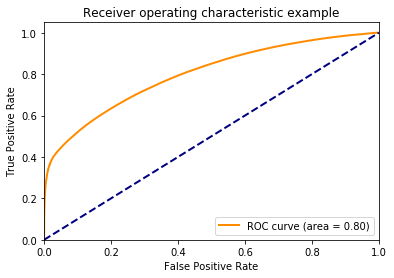

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Check original ManTraNet performance
manTraNet_origin = modelCore.load_pretrain_model_by_index( 0, manTraNet_modelDir )

INFO: use activation in the last CONV=tanh
INFO: unfreeze feature extraction part, trainable=True
INFO: freeze image_in
INFO: freeze b1c1
INFO: freeze b1c2
INFO: freeze b2c1
INFO: freeze b2c2


In [9]:
manTraNet_origin.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
preds = manTraNet_origin.evaluate(X_test, Y_test, batch_size=20, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1000/1000 [==============================] - 256s 256ms/step

Loss = 0.2803629846870899
Test Accuracy = 0.9193386542797088


In [11]:
y_pred=manTraNet_origin.predict(X_test)

In [12]:
Y_test = Y_test.reshape((Y_test.shape[0] * Y_test.shape[1] * Y_test.shape[2]))
Y_test = Y_test > 0.5

In [13]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
Y_pred = y_pred.copy()
Y_pred = Y_pred.reshape((Y_pred.shape[0] * Y_pred.shape[1] * Y_pred.shape[2]))
print(Y_pred.shape, Y_pred.dtype)
print(Y_test.shape, Y_test.dtype)
#cm=confusion_matrix(Y_test,Y_pred)
#print(cm)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
AUC = metrics.auc(fpr, tpr)

(50176000,) float32
(50176000,) bool


In [14]:
# export and save data
import scipy.io as sio
sio.savemat('dean1_LADNsmall_mantranet',{'tpr':tpr, 'fpr':fpr, 'AUC': AUC, 'TestLoss':preds[0], 'TestACC':preds[1]})

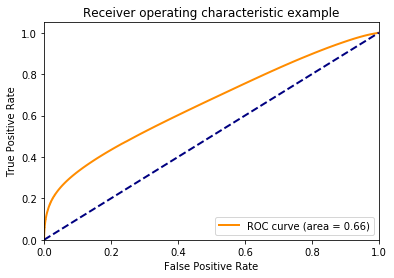

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()